In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import plot_model


In [2]:
train_data = tfds.load("cats_vs_dogs",split="train[:80%]",as_supervised=True)
validation_data = tfds.load("cats_vs_dogs",split="train[80%:90%]",as_supervised=True)
test_data = tfds.load("cats_vs_dogs",split="train[:-10%]",as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete4CD95D/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
IMAGE_SIZE = (300,300)

In [4]:
#preprocessing data
def preprocess(images,label):
  image = tf.cast(images,"float32")/255.0

  image = tf.image.resize(image,IMAGE_SIZE)

  return image,label

In [5]:
normalized_train_data = train_data.map(preprocess)
normalized_test_data = test_data.map(preprocess)
normalized_validation_data = validation_data.map(preprocess)

In [6]:
#creating batches
train_batches = normalized_train_data.shuffle(1024).batch(32)

In [7]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,GlobalAveragePooling2D,Dense
from tensorflow.keras.models import Model,Sequential

In [8]:
model = Sequential()
model.add(Conv2D(16,(3,3),padding="same",activation="relu",input_shape=(300,300,3)))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(32,(3,3),padding="same",activation="relu"))
model.add(MaxPool2D((2,2)))
model.add(Conv2D(64,(3,3),padding="same",activation="relu"))
model.add(MaxPool2D((2,2)))

model.add(Conv2D(128,(3,3),padding="same",activation="relu"))
model.add(GlobalAveragePooling2D())

model.add(Dense(1,activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 300, 300, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 150, 150, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 128)       7

In [9]:
model.compile(loss="binary_crossentropy",
              optimizer = tf.keras.optimizers.RMSprop(lr=0.001),
              metrics=["acc"])
hist  = model.fit(train_batches,epochs=25)

Epoch 1/25
582/582 [==============================] - 129s 206ms/step - loss: 0.6801 - acc: 0.5555
Epoch 2/25
582/582 [==============================] - 123s 207ms/step - loss: 0.6423 - acc: 0.6243
Epoch 3/25
582/582 [==============================] - 121s 204ms/step - loss: 0.6136 - acc: 0.6588
Epoch 4/25
582/582 [==============================] - 120s 203ms/step - loss: 0.5933 - acc: 0.6898
Epoch 5/25
582/582 [==============================] - 120s 203ms/step - loss: 0.5819 - acc: 0.6957
Epoch 6/25
582/582 [==============================] - 120s 203ms/step - loss: 0.5618 - acc: 0.7133
Epoch 7/25
582/582 [==============================] - 120s 203ms/step - loss: 0.5498 - acc: 0.7229
Epoch 8/25
582/582 [==============================] - 120s 202ms/step - loss: 0.5461 - acc: 0.7298
Epoch 9/25
582/582 [==============================] - 119s 201ms/step - loss: 0.5304 - acc: 0.7460
Epoch 10/25
582/582 [==============================] - 121s 205ms/step - loss: 0.5239 - acc: 0.7482
Epoch 11/

In [10]:
model.layers[-1].name,model.layers[-3].name

('dense', 'conv2d_3')

In [23]:
#now extractin the weights of final dense layer
gap_weight = model.layers[-1].get_weights()[0]
cam_model = Model(inputs = model.input,outputs=[model.layers[-3].output,
                                                model.layers[-1].output])

In [24]:
gap_weight.shape

(128, 1)

In [28]:
gap_weight[:,0].shape

(128,)

In [31]:
import scipy as sp

In [85]:
def show_camera(image_value,feature,result):
  feature = feature[0]
  prediction = result[0]

  class_activation_map = gap_weight[:,0]

  class_activation_feature = sp.ndimage.zoom(feature,(300/37,300/37,1),order=2)

  cam_output = np.dot(class_activation_feature,class_activation_map)


  plt.figure(figsize=(8,8))
  plt.axis("off")
  plt.imshow(cam_output,cmap="jet",alpha=0.5)
  plt.imshow(tf.squeeze(image_value),alpha=0.6)
  plt.show()

In [88]:
test_batch = normalized_test_data.shuffle(256).batch(1)

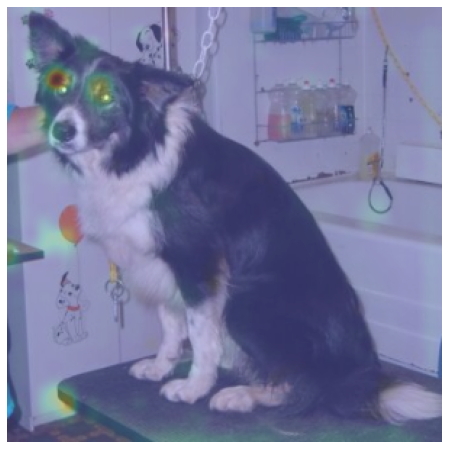

In [89]:
for image,lbl in test_batch.take(1):
  features,result = cam_model.predict(image)
  show_camera(image,features,result)

In [93]:
def random_image(img):
  img = cv2.imread(img)

  img = cv2.resize(img,(300,300))/255.

  img = tf.expand_dims(img,axis=0)

  feature,result = cam_model(img)

  show_camera(img,feature,result)

In [94]:
!wget -O dog2.jpg https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg

--2021-01-14 11:57:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/MLColabImages/dog2.jpg
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 66.102.1.128, 74.125.206.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494803 (483K) [image/jpeg]
Saving to: ‘dog2.jpg’

dog2.jpg            100%[===================>] 483.21K  --.-KB/s    in 0.008s  

2021-01-14 11:57:25 (60.8 MB/s) - ‘dog2.jpg’ saved [494803/494803]



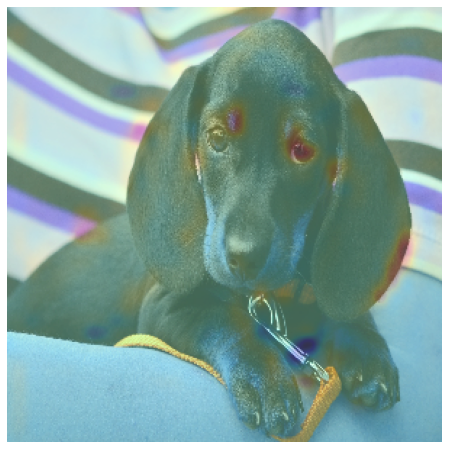

In [95]:
random_image("dog2.jpg")